In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

In [3]:
# CZ4042 Project Part A
NUM_CLASSES = 3

epochs = 1000
batch_size = 32
num_neurons = 10
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

histories = {}
times = np.zeros((1,5))

#read train data
train_input = np.genfromtxt('/content/gdrive/My Drive/CZ4042 Assign1/ctg_data_cleaned.csv', delimiter= ',')
X, Y_ = train_input[1:, :21], train_input[1:,-1].astype(int)
Y = Y_ - np.ones(Y_.shape)

#idx = np.arange(len(X))
#np.random.shuffle(idx)
#X, Y = X[idx], Y[idx]

#Split train test 70-30
#splitnum = int(0.7*(X.shape[0]))
#trainX_, trainY = X[:splitnum], Y[:splitnum] 
#testX_, testY = X[splitnum:], Y[splitnum:] 

trainX_, testX_, trainY, testY = train_test_split(X, Y, test_size=0.3, 
                                                  shuffle=True, random_state=seed,) #stratify=Y)  # Need to stratify & shuffle??

scaler = MinMaxScaler()
trainX = scaler.fit_transform(trainX_)
testX = scaler.transform(testX_)


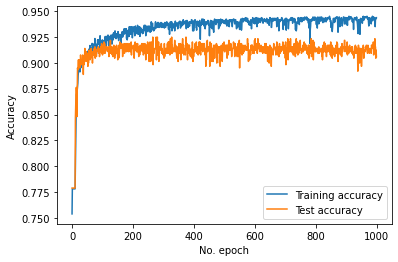

In [ ]:
# QUESTION 1 a
keras.backend.clear_session()
model1 = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu', 
                      kernel_regularizer=keras.regularizers.l2(1e-6)),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
history1 = model1.fit(trainX, trainY,
                      epochs=epochs,
                      verbose = 0,
                      batch_size=batch_size,
                      shuffle=True,       # Need to shuffle ??
                      validation_data=(testX,testY))

# plot learning curves
plt.plot(history1.history['accuracy'], label='Training accuracy')
plt.plot(history1.history['val_accuracy'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

# Around 250 Epochs, test performance stabilizes

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
      

In [ ]:
# Manual K-Fold, Question 2
keras.backend.clear_session()
NUM_CLASSES = 3
epochs = 1000  # cant use 250 since diff batch sizes have diff convergence
seed = 10
 
np.random.seed(seed)
tf.random.set_seed(seed)
 
numfolds = 5
foldsize = np.rint(len(trainX) / 5)
 
batchlist = [4,8,16,32,64]
times = np.zeros((len(batchlist),1))
acc = []
 
cvacc = {}
 
idx = np.arange(len(trainX))
np.random.shuffle(idx)
trainX, trainY = trainX[idx], trainY[idx]
 
for idx, batch in enumerate(batchlist):
    times_ = np.zeros(times.shape)
    acc_ = []
    cvacc_ = np.zeros((epochs,))
    for fold in range(numfolds):
        # keras.backend.clear_session()
        if fold == (numfolds - 1):
            start, end = int(fold*foldsize), int(len(trainX))
        else:
            start, end = int(fold*foldsize), int((fold+1)*foldsize)
        
        x_val, y_val = trainX[start:end], trainY[start:end]
        x_train  = np.append(trainX[:start], trainX[end:], axis=0)
        y_train = np.append(trainY[:start], trainY[end:], axis=0) 
 
        starter_model = keras.Sequential([
            keras.layers.Dense(num_neurons, activation='relu', 
                              kernel_regularizer=keras.regularizers.l2(1e-6)),
            keras.layers.Dense(NUM_CLASSES, activation='softmax'),
        ])
 
        starter_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        
        time_callback = TimeHistory()
 
        history = starter_model.fit(x_train, y_train,
                                    epochs=epochs,
                                    batch_size = batch,  # vary the batch size
                                    verbose=0,
                                    callbacks=[time_callback],
                                    shuffle=True,
                                    use_multiprocessing=False,
                                    validation_data=(x_val, y_val))
 
        cvacc_ = cvacc_ + np.array(history.history['val_accuracy'])
        acc_.append(history.history['val_accuracy'][epochs-1]) # Record val acc for that fold
        times_[fold,0] = np.mean(time_callback.times)  # Average epoch time in 1 fold
        print('Fold %d test accuracy %g'%(fold+1, acc_[fold]))
    
    times[idx,0] = np.mean(times_)  # Average epoch time across all folds, for particular batch size
    acc.append(np.mean(acc_))
    cvacc[batch] = cvacc_ / numfolds 
 
    print('* Batch size: %d, Mean cv accuracy = %g, Avg epoch time = %gs *'%(batch, acc[idx], times[idx,0]))
    print('--------')

Fold 1 test accuracy 0.902685
Fold 2 test accuracy 0.869128
Fold 3 test accuracy 0.946309
Fold 4 test accuracy 0.865772
Fold 5 test accuracy 0.868243
* Batch size: 4, Mean cv accuracy = 0.890427, Avg epoch time = 0.268937s *
--------
Fold 1 test accuracy 0.855705
Fold 2 test accuracy 0.885906
Fold 3 test accuracy 0.912752
Fold 4 test accuracy 0.85906
Fold 5 test accuracy 0.891892
* Batch size: 8, Mean cv accuracy = 0.881063, Avg epoch time = 0.142736s *
--------
Fold 1 test accuracy 0.909396
Fold 2 test accuracy 0.855705
Fold 3 test accuracy 0.912752
Fold 4 test accuracy 0.879195
Fold 5 test accuracy 0.871622
* Batch size: 16, Mean cv accuracy = 0.885734, Avg epoch time = 0.0804986s *
--------
Fold 1 test accuracy 0.902685
Fold 2 test accuracy 0.872483
Fold 3 test accuracy 0.916107
Fold 4 test accuracy 0.869128
Fold 5 test accuracy 0.888514
* Batch size: 32, Mean cv accuracy = 0.889783, Avg epoch time = 0.0487036s *
--------
Fold 1 test accuracy 0.909396
Fold 2 test accuracy 0.88255
Fo

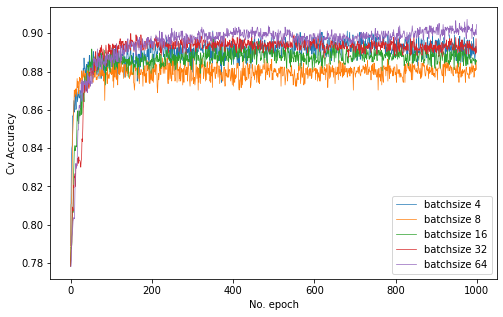

In [ ]:
# plot cv accuracies against epochs
plt.figure(figsize=(8,5))
for num in batchlist:
  plt.plot(cvacc[num], label='batchsize %d'%num, linewidth=0.7)
plt.ylabel('Cv Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

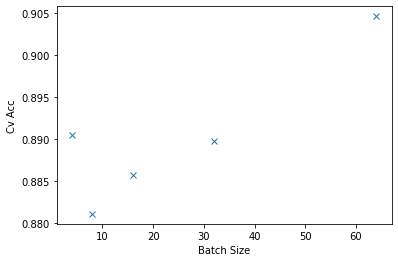

In [ ]:
# plot cv accuracy against batch size
plt.plot(batchlist, acc,  marker = 'x', linestyle = 'None')
plt.ylabel('Cv Acc')
plt.xlabel('Batch Size')
plt.show()


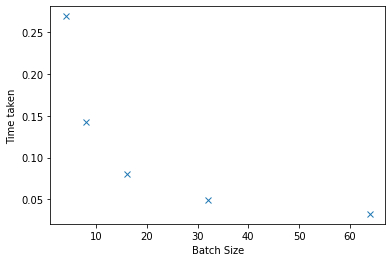

In [ ]:
# plot time taken against batch size
plt.plot(batchlist, times,  marker = 'x', linestyle = 'None')
plt.ylabel('Time taken')
plt.xlabel('Batch Size')
plt.show()


In [ ]:
myMetric = np.divide(np.array(acc).reshape(5,1),times)  
maxIdx = np.argmax(myMetric)
print('Best batch size: %d' %batchlist[maxIdx])  
# CV accuracies are relatively similar, but time taken per epoch shows a big variance
# From 200 epochs onwards, batch size 64 shows the highest cross validation accuracy. 
# At batch size = 64, cv accuracy is highest and epoch time is smallest, so it is ideal

Best batch size: 64


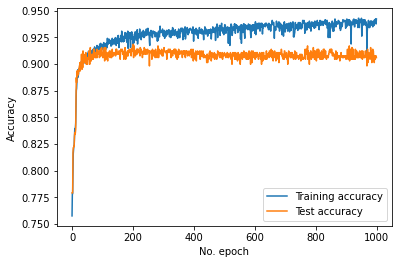

In [ ]:
# Qn 2c
keras.backend.clear_session()
batch_size = 64   # Choose best batch size 

model2 = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu', 
                      kernel_regularizer=keras.regularizers.l2(1e-6)),
    keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
history2 = model2.fit(trainX, trainY,
                      epochs=1000,
                      verbose = 0,
                      shuffle=True,
                      batch_size=batch_size,
                      validation_data=(testX, testY))

# plot learning curves
plt.plot(history2.history['accuracy'], label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

# We can see that learning curves are more stable with smaller fluctuations in value, test acc converges earlier (200 epochs)

In [ ]:
# Manual K-Fold, Question 3
NUM_CLASSES = 3
epochs = 1000
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 64  # Best batch size
numfolds = 5
foldsize = np.rint(len(trainX) / numfolds)  # Size of dataset within the fold

neuronlist = [5,10,15,20,25]
acc = []
cvacc = {}

for idx, neuron in enumerate(neuronlist):
    acc_ = []
    cvacc_ = np.zeros((epochs,))
    for fold in range(numfolds):
        if fold == (numfolds - 1):
            start, end = int(fold*foldsize), int(len(trainX))
        else:
            start, end = int(fold*foldsize), int((fold+1)*foldsize)
        
        x_val, y_val = trainX[start:end], trainY[start:end]
        x_train  = np.append(trainX[:start], trainX[end:], axis=0)
        y_train = np.append(trainY[:start], trainY[end:], axis=0) 

        starter_model = keras.Sequential([
            keras.layers.Dense(neuron, activation='relu',   # Vary the number of neurons
                              kernel_regularizer=keras.regularizers.l2(1e-6)),
            keras.layers.Dense(NUM_CLASSES, activation='softmax'),
        ])

        starter_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        
        history = starter_model.fit(x_train, y_train,
                                    epochs=epochs,
                                    batch_size = batch_size,
                                    verbose=0,
                                    use_multiprocessing=False,
                                    shuffle=True,
                                    validation_data=(x_val, y_val))
        
        cvacc_ = cvacc_ + np.array(history.history['val_accuracy'])
        acc_.append(history.history['val_accuracy'][epochs-1]) # Record val acc for that fold
        print('Fold %d test accuracy %g'%(fold+1, acc_[fold]))
    
    acc.append(np.mean(acc_))
    cvacc[neuron] = cvacc_ / numfolds 

    print('* Num of Neurons: %d, Mean cv accuracy = %g *'%(neuron, acc[idx]))
    print('--------')

Fold 1 test accuracy 0.909396
Fold 2 test accuracy 0.822148
Fold 3 test accuracy 0.912752
Fold 4 test accuracy 0.902685
Fold 5 test accuracy 0.89527
* Num of Neurons: 5, Mean cv accuracy = 0.88845 *
--------
Fold 1 test accuracy 0.926175
Fold 2 test accuracy 0.825503
Fold 3 test accuracy 0.916107
Fold 4 test accuracy 0.912752
Fold 5 test accuracy 0.878378
* Num of Neurons: 10, Mean cv accuracy = 0.891783 *
--------
Fold 1 test accuracy 0.919463
Fold 2 test accuracy 0.838926
Fold 3 test accuracy 0.892617
Fold 4 test accuracy 0.912752
Fold 5 test accuracy 0.881757
* Num of Neurons: 15, Mean cv accuracy = 0.889103 *
--------
Fold 1 test accuracy 0.926175
Fold 2 test accuracy 0.845638
Fold 3 test accuracy 0.919463
Fold 4 test accuracy 0.916107
Fold 5 test accuracy 0.902027
* Num of Neurons: 20, Mean cv accuracy = 0.901882 *
--------
Fold 1 test accuracy 0.936242
Fold 2 test accuracy 0.83557
Fold 3 test accuracy 0.912752
Fold 4 test accuracy 0.90604
Fold 5 test accuracy 0.888514
* Num of Ne

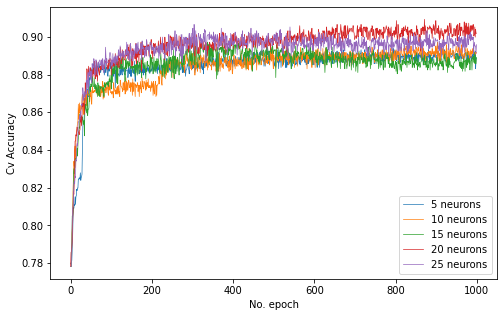

In [ ]:
# plot cv accuracies against epochs
plt.figure(figsize=(8,5))
for num in neuronlist:
  plt.plot(cvacc[num], label='%d neurons'%num, linewidth=0.7)
plt.ylabel('Cv Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

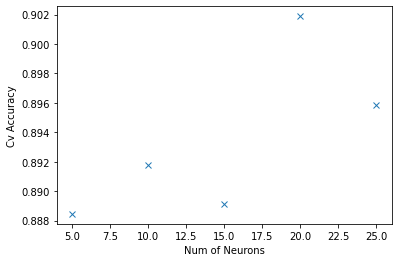

In [ ]:
# plot CV accuracy against number of neurons
plt.plot(neuronlist, acc,  marker = 'x', linestyle = 'None')
plt.ylabel('Cv Accuracy')
plt.xlabel('Num of Neurons')
plt.show()

# Using CV accuracy at convergence as the metric for comparison, choose 20 neurons

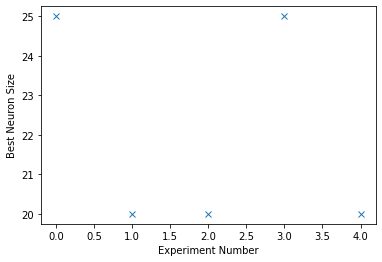

In [37]:
# Confirm by doing multiple experiments

NUM_CLASSES = 3
epochs = 700  # Since performance stabilizes at 700 epochs, based on above learning curve
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 64  # Best batch size
numfolds = 5
foldsize = np.rint(len(trainX) / numfolds)  # Size of dataset within the fold

neuronlist = [5,10,15,20,25]
cvacc = {}
exp_list = []
num_experiments = 5   # Perform 5 experiments

for n in range(num_experiments):    # Conduct experiments 
    acc = []
    for idx, neuron in enumerate(neuronlist):
        acc_ = []
        cvacc_ = np.zeros((epochs,))
        for fold in range(numfolds):
            if fold == (numfolds - 1):
                start, end = int(fold*foldsize), int(len(trainX))
            else:
                start, end = int(fold*foldsize), int((fold+1)*foldsize)
            
            x_val, y_val = trainX[start:end], trainY[start:end]
            x_train  = np.append(trainX[:start], trainX[end:], axis=0)
            y_train = np.append(trainY[:start], trainY[end:], axis=0) 

            starter_model = keras.Sequential([
                keras.layers.Dense(neuron, activation='relu',   # Vary the number of neurons
                                  kernel_regularizer=keras.regularizers.l2(1e-6)),
                keras.layers.Dense(NUM_CLASSES, activation='softmax'),
            ])

            starter_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
            
            history = starter_model.fit(x_train, y_train,
                                        epochs=epochs,
                                        batch_size = batch_size,
                                        verbose=0,
                                        use_multiprocessing=False,
                                        shuffle=True,
                                        validation_data=(x_val, y_val))
            
            cvacc_ = cvacc_ + np.array(history.history['val_accuracy'])
            acc_.append(history.history['val_accuracy'][epochs-1]) # Record last epoch val acc for that fold
        
        acc.append(np.mean(acc_)) # Get cross-val acc for that particular neuron value
        cvacc[neuron] = cvacc_ / numfolds 

    exp_list.append(np.argmax(acc))   # Record for that experiment, what was the best neuron case

# Plot it out
best_list = []
for arg in exp_list:
  best_list.append(neuronlist[arg])

plt.plot(range(num_experiments),best_list, marker = 'x', linestyle = 'None')
plt.ylabel('Best Neuron Size')
plt.xlabel('Experiment Number')
plt.show()        # Confirms that best Neuron number is 20 in 3/5 experiments

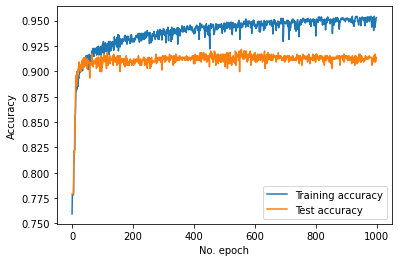

In [ ]:
# Qn 3c
keras.backend.clear_session()
batch_size = 64   # Choose best batch size 
num_neurons_optimal = 20  # Choose best neuron number 

model2 = keras.Sequential([
    keras.layers.Dense(num_neurons_optimal, activation='relu', 
                      kernel_regularizer=keras.regularizers.l2(1e-6)),
    keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
history2 = model2.fit(trainX, trainY,
                      epochs=1000,
                      verbose = 0,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_data=(testX, testY))

# plot learning curves
plt.plot(history2.history['accuracy'], label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

# Better training and validation accuracy

In [ ]:
# Qn 4: Finding weight decay parameter
NUM_CLASSES = 3
epochs = 1000
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 64  # Best batch size 
num_neurons = 20  # Best num of neurons 
numfolds = 5
foldsize = np.rint(len(trainX) / numfolds)

decaylist = [0,1e-3,1e-6,1e-9,1e-12]
acc = []
cvacc = {}

for idx, decay in enumerate(decaylist):
    acc_ = []
    cvacc_ = np.zeros((epochs,))
    for fold in range(numfolds):
        #keras.backend.clear_session()  
        if fold == (numfolds - 1):
            start, end = int(fold*foldsize), int(len(trainX))
        else:
            start, end = int(fold*foldsize), int((fold+1)*foldsize)
        
        x_val, y_val = trainX[start:end], trainY[start:end]
        x_train  = np.append(trainX[:start], trainX[end:], axis=0)
        y_train = np.append(trainY[:start], trainY[end:], axis=0) 

        starter_model = keras.Sequential([
            keras.layers.Dense(num_neurons, activation='relu', 
                              kernel_regularizer=keras.regularizers.l2(decay)), # Vary decay parameter
            keras.layers.Dense(NUM_CLASSES, activation='softmax'),
        ])

        starter_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        
        history = starter_model.fit(x_train, y_train,
                                    epochs=epochs,
                                    batch_size = batch_size,
                                    verbose=0,
                                    use_multiprocessing=False,
                                    shuffle=True,
                                    validation_data=(x_val, y_val))
        
        cvacc_ = cvacc_ + np.array(history.history['val_accuracy'])
        acc_.append(history.history['val_accuracy'][epochs-1]) # Record val acc for that fold
        print('Fold %d test accuracy %g'%(fold+1, acc_[fold]))
    
    acc.append(np.mean(acc_))
    cvacc[str(decay)] = cvacc_ / numfolds 

    print('* Decay parameter: %g, Mean cv accuracy = %g *'%(decay, acc[idx]))
    print('--------')

Fold 1 test accuracy 0.926175
Fold 2 test accuracy 0.818792
Fold 3 test accuracy 0.912752
Fold 4 test accuracy 0.916107
Fold 5 test accuracy 0.888514
* Decay parameter: 0, Mean cv accuracy = 0.892468 *
--------
Fold 1 test accuracy 0.922819
Fold 2 test accuracy 0.828859
Fold 3 test accuracy 0.899329
Fold 4 test accuracy 0.922819
Fold 5 test accuracy 0.912162
* Decay parameter: 0.001, Mean cv accuracy = 0.897198 *
--------
Fold 1 test accuracy 0.92953
Fold 2 test accuracy 0.822148
Fold 3 test accuracy 0.926175
Fold 4 test accuracy 0.912752
Fold 5 test accuracy 0.902027
* Decay parameter: 1e-06, Mean cv accuracy = 0.898526 *
--------
Fold 1 test accuracy 0.912752
Fold 2 test accuracy 0.822148
Fold 3 test accuracy 0.916107
Fold 4 test accuracy 0.912752
Fold 5 test accuracy 0.875
* Decay parameter: 1e-09, Mean cv accuracy = 0.887752 *
--------
Fold 1 test accuracy 0.909396
Fold 2 test accuracy 0.832215
Fold 3 test accuracy 0.92953
Fold 4 test accuracy 0.932886
Fold 5 test accuracy 0.888514

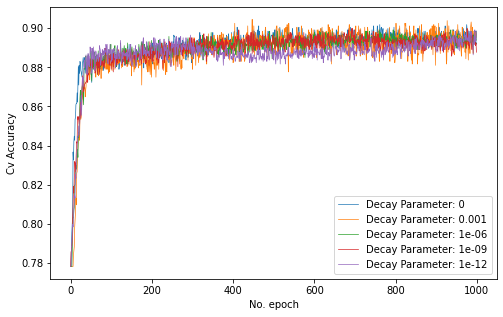

In [ ]:
# plot cv accuracies against epochs
plt.figure(figsize=(8,5))
for num in decaylist:
  plt.plot(cvacc[str(num)], label='Decay Parameter: %s'%str(num), linewidth=0.7)
plt.ylabel('Cv Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

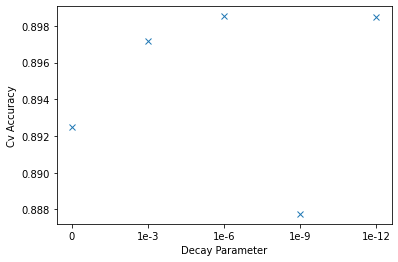

In [ ]:
# plot CV accuracy against decay parameters
plt.plot(['0','1e-3','1e-6','1e-9','1e-12'], acc,  marker = 'x', linestyle = 'None')
plt.ylabel('Cv Accuracy')
plt.xlabel('Decay Parameter')
plt.show()
# All are comparable, not a big effect. Decay parameter = 1e-6 is best due to highest cv acc

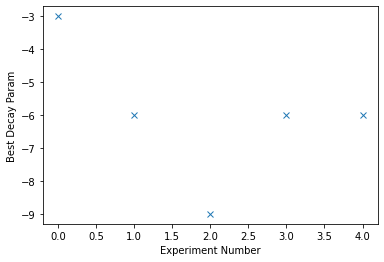

In [38]:
# Confirm by doing multiple experiments

NUM_CLASSES = 3
epochs = 700  # Since performance stabilizes at 700 epochs based on above learning curve
seed = 10

np.random.seed(seed)
tf.random.set_seed(seed)

batch_size = 64  # Best batch size
num_neurons = 20   # Best neuron number
numfolds = 5
foldsize = np.rint(len(trainX) / numfolds)  # Size of dataset within the fold

decaylist = [0,1e-3,1e-6,1e-9,1e-12]
cvacc = {}
exp_list = []
num_experiments = 5   # Perform 5 experiments

for n in range(num_experiments):    # Conduct experiments 
    acc = []
    for idx, decay in enumerate(decaylist):
        acc_ = []
        cvacc_ = np.zeros((epochs,))
        for fold in range(numfolds):
            #keras.backend.clear_session()  
            if fold == (numfolds - 1):
                start, end = int(fold*foldsize), int(len(trainX))
            else:
                start, end = int(fold*foldsize), int((fold+1)*foldsize)
            
            x_val, y_val = trainX[start:end], trainY[start:end]
            x_train  = np.append(trainX[:start], trainX[end:], axis=0)
            y_train = np.append(trainY[:start], trainY[end:], axis=0) 

            starter_model = keras.Sequential([
                keras.layers.Dense(num_neurons, activation='relu', 
                                  kernel_regularizer=keras.regularizers.l2(decay)), # Vary decay parameter
                keras.layers.Dense(NUM_CLASSES, activation='softmax'),
            ])

            starter_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                          loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])
            
            history = starter_model.fit(x_train, y_train,
                                        epochs=epochs,
                                        batch_size = batch_size,
                                        verbose=0,
                                        use_multiprocessing=False,
                                        shuffle=True,
                                        validation_data=(x_val, y_val))
            
            cvacc_ = cvacc_ + np.array(history.history['val_accuracy'])
            acc_.append(history.history['val_accuracy'][epochs-1]) # Record val acc for that fold
        
        acc.append(np.mean(acc_))
        cvacc[str(decay)] = cvacc_ / numfolds 

    exp_list.append(np.argmax(acc))   # Record for that experiment, what was the best decay parameter

# Plot it out
best_list = []
for arg in exp_list:
  best_list.append(np.log10(decaylist[arg]))

plt.plot(range(num_experiments),best_list, marker = 'x', linestyle = 'None')
plt.ylabel('Best Decay Param')
plt.xlabel('Experiment Number')
plt.show()     # Confirms that best decay parameter is 1e-6 for 3/5 experiments 

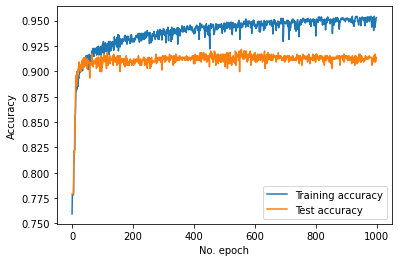

In [ ]:
# Qn 4c
keras.backend.clear_session()
batch_size = 64   # Choose best batch size 
num_neurons = 20 # Choose best neuron number 
decaynum = 1e-6 # Choose best decay parameter
epochs= 1000

model2 = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu', 
                      kernel_regularizer=keras.regularizers.l2(decaynum)),
    keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
history2 = model2.fit(trainX, trainY,
                      epochs=epochs,
                      verbose = 0,
                      batch_size=batch_size,
                      shuffle=True,
                      validation_data=(testX, testY))

# plot learning curves
plt.plot(history2.history['accuracy'], label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

# Optimized 3-layer model Converges at around 91% Test accuracy

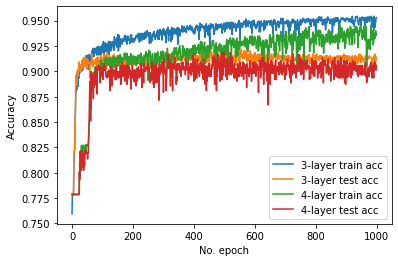

In [ ]:
# Qn 5: Using a 4 Layer Model
keras.backend.clear_session()
batch_size = 32  
num_neurons = 20 
decaynum = 1e-6 
epochs = 1000

model5 = keras.Sequential([
    keras.layers.Dense(num_neurons, activation='relu', 
                      kernel_regularizer=keras.regularizers.l2(decaynum)),
    keras.layers.Dense(num_neurons, activation='relu',
                       kernel_regularizer=keras.regularizers.l2(decaynum)),
    keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

model5.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model
history5 = model5.fit(trainX, trainY,
                      epochs= epochs,
                      verbose = 0,
                      batch_size=batch_size,
                      shuffle = True,
                      validation_data=(testX, testY))

# plot learning curves
plt.plot(history2.history['accuracy'], label='3-layer train acc')
plt.plot(history2.history['val_accuracy'], label='3-layer test acc')
plt.plot(history5.history['accuracy'], label='4-layer train acc')
plt.plot(history5.history['val_accuracy'], label='4-layer test acc')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

# Optimal 3-layer model achieves test accuracy of 91.7%, while 4-layer model achieves test accuracy of around 91% 
# Both achieve test accuracy convergence at around 100 epochs
# Better test accuracy at convergence: Optimized 3-layer model, less noise 

In [ ]:
print('--Model Comparison--')
print('Optimal 3-layer Model')
print('   Highest test accuracy: %g' %np.max(history2.history['val_accuracy']))
print('   At epoch: %d' %np.argmax(history2.history['val_accuracy']))
print('--')
print('4-layer Model')
print('  Highest test accuracy: %g' %np.max(history5.history['val_accuracy']))
print('  At epoch: %d' %np.argmax(history5.history['val_accuracy']))

# Both models trained for 1000 epochs
# Optimal 3-layer model achieves peak test accuracy of 92.2% in 556 epochs 
# 4-layer model hyperparameters not 'optimized' yet, takes 491 epochs to reach peak test accuracy of 91.8% (comparable performance)
# This shows that an unoptimized deeper model can potentially outperform an optimized, shallower model
# Which implies that the benefits of a deeper network architecture are more significant than the benefits from hyperparameter tuning
# But perhaps only at the initial stage, when comparing relatively shallow neural networks (3 layer vs 4 layer)

--Model Comparison--
Optimal 3-layer Model
   Highest test accuracy: 0.92163
   At epoch: 556
--
4-layer Model
  Highest test accuracy: 0.918495
  At epoch: 491
